## 3.1 Tiling Calculations

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt

# scaling constants
B = 8
KB = 1024
MB = KB * 1024
GB = MB * 1024


In [2]:
"""_summary_
R = filter height
S = filter width
C = input channels
M = filter (output) channels
P = output feature map height
Q = output feature map width
L = cache line size (4B for fp32, 1B for uint8)
T = tile size (4B for fp32, 1B for uint8)
"""
def get_tiling_comparison(R, S, C, M, P, Q, L, T):
    cache_miss_wo_tiling = ((C*R*S)/L) * (P*Q*M) + C*R*S*P*Q*M + ((P*Q*M)/L)

    cache_miss_w_tiling = (2*C*R*S*P*Q*M)/(L*T) + (P*Q*M)/L

    print(f"cache misses without tiling: {round(cache_miss_wo_tiling, 3)}")
    print(f"cache misses with tiling: {round(cache_miss_w_tiling, 3)}")

    factor = round(cache_miss_wo_tiling / cache_miss_w_tiling, 3)
    print(f"factor: {factor}")
    
    # * multiply T by 4 for fp32, 1 for uint8
    mem_use = round((3 * ((T*4)**2)) / KB, 3)
    print(f"mem use: {mem_use}KB")
    
    # horizontal/vertical tile loads weights
    # h_tiles_w = (C*R*S) / T
    # v_tiles_w = M / T
    
    # # horizontal/vertical tile loads input feature maps
    # h_tiles_if = (P*Q) / T
    # v_tiles_if = (C*R*S) / T
    
    # # horizontal/vertical tile loads output feature maps
    # h_tiles_of = (P*Q) / T
    # v_tiles_of = M / T

    # tile_loads = round(h_tiles_w * v_tiles_w + h_tiles_if * v_tiles_if + h_tiles_of * v_tiles_of, 3)
    # print(f"min tile loads: {tile_loads}")

# Conv 1
print("Conv 1 L1D")
get_tiling_comparison(5, 5, 3, 32, 60, 60, 16, 25)
print()

print("Conv 1 L1D, L2")
get_tiling_comparison(5, 5, 3, 32, 60, 60, 16, 150)
print()

print("Conv 1 L1D, L2, L3")
get_tiling_comparison(5, 5, 3, 32, 60, 60, 16, 600)
print()


# Conv 2
print("Conv 2 L1D")
get_tiling_comparison(5, 5, 32, 32, 56, 56, 16, 25)
print()

print("Conv 2 L1D, L2")
get_tiling_comparison(5, 5, 32, 32, 56, 56, 16, 100)
print()

print("Conv 2 L1D, L2, L3")
get_tiling_comparison(5, 5, 32, 32, 56, 56, 16, 800)
print()


Conv 1 L1D
cache misses without tiling: 9187200.0
cache misses with tiling: 50400.0
factor: 182.286
mem use: 29.297KB

Conv 1 L1D, L2
cache misses without tiling: 9187200.0
cache misses with tiling: 14400.0
factor: 638.0
mem use: 1054.688KB

Conv 1 L1D, L2, L3
cache misses without tiling: 9187200.0
cache misses with tiling: 9000.0
factor: 1020.8
mem use: 16875.0KB

Conv 2 L1D
cache misses without tiling: 85305472.0
cache misses with tiling: 407680.0
factor: 209.246
mem use: 29.297KB

Conv 2 L1D, L2
cache misses without tiling: 85305472.0
cache misses with tiling: 106624.0
factor: 800.059
mem use: 468.75KB

Conv 2 L1D, L2, L3
cache misses without tiling: 85305472.0
cache misses with tiling: 18816.0
factor: 4533.667
mem use: 30000.0KB



## Memory Access Patterns

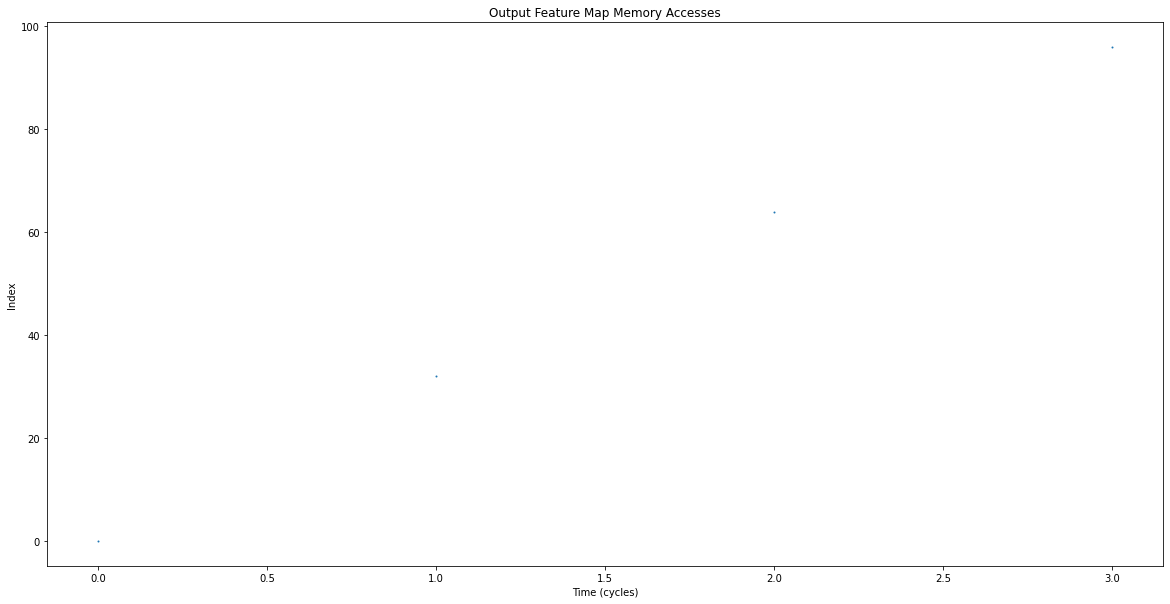

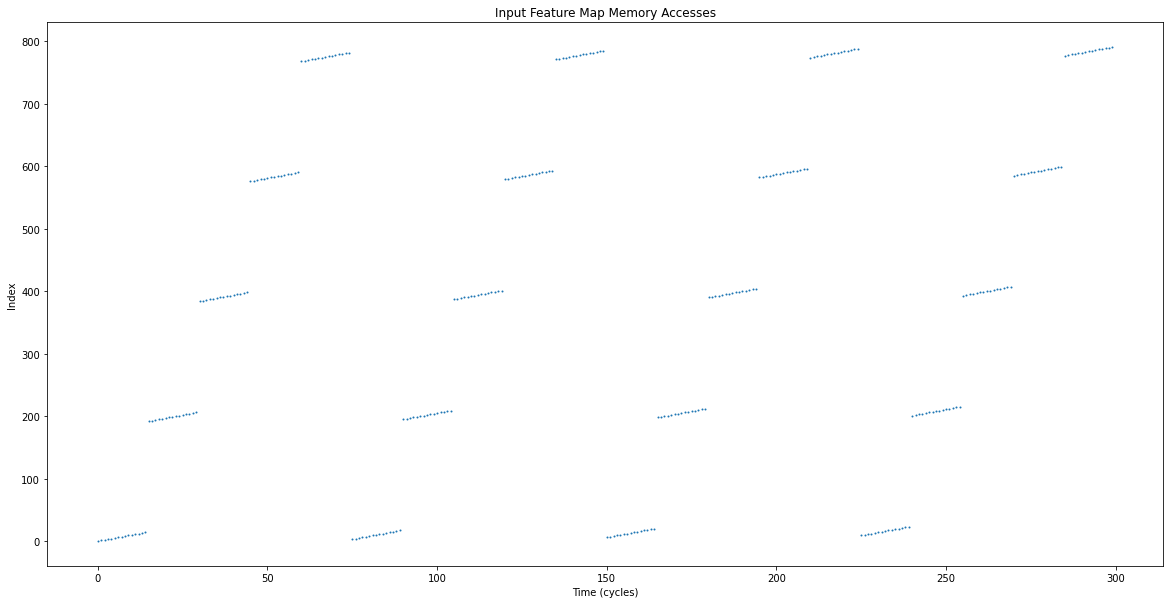

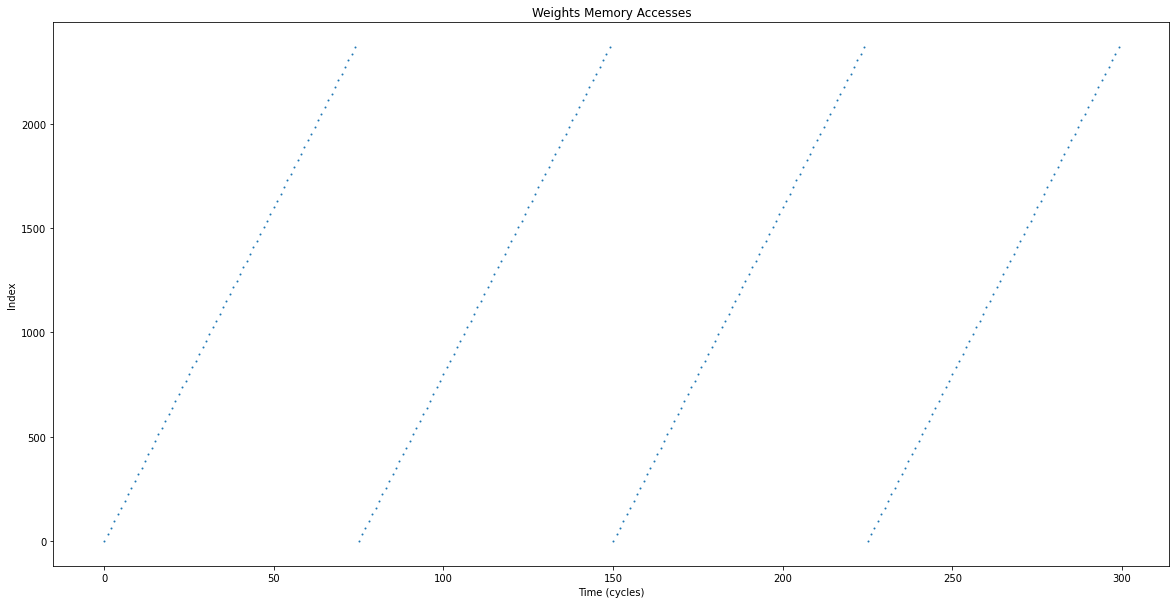

In [26]:
# plot cache access patterns for each layer

# y axis will have index of array access
# x axis will have time (cycles)
# there will be 3 separate graphs, 1 for output feature map, 1 for input feature map, 1 for weights

"""_summary_
R = filter height
S = filter width
C = input channels
M = filter (output) channels
H = input feature map height
W = input feature map width
P = output feature map height
Q = output feature map width
L = cache line size (4B for fp32, 1B for uint8)
T = tile size (4B for fp32, 1B for uint8)
"""
def show_mem_access_graph1(R, S, C, M, H, W, P, Q, L, T):
    # output feature map (60x60x32)
    # of_map_accesses = np.zeros(P*Q*M)
    of_map_accesses = []
    # input feature map (64x64x3)
    # if_map_accesses = np.zeros(H*W*C)
    if_map_accesses = []
    # weights (5x5x3x32)
    # w_accesses = np.zeros(R*S*C*M)
    w_accesses = []
    for filter_chan in range(M):
        if filter_chan == 1:
            break
        for of_map_row in range(P):
            if of_map_row == 1:
                break
            for of_map_col in range(Q):
                of_map_accesses.append(of_map_row*Q*M + of_map_col*M + filter_chan)
                if_map_row_limit = of_map_row + R
                if_map_col_limit = of_map_col + S
                for row_idx in range(of_map_row, if_map_row_limit):
                    for col_idx in range(of_map_col, if_map_col_limit):
                        for chan_idx in range(C):
                            if_map_accesses.append(row_idx*W*C + col_idx*C + chan_idx)
                            w_accesses.append((row_idx-of_map_row)*S*C*M + (col_idx-of_map_col)*C*M + chan_idx*M + filter_chan)
                if of_map_col == 3:
                    break
    
    
    # create 3 separate dot plots
    plt.figure(figsize=(20, 10))
    plt.scatter(range(len(of_map_accesses)), of_map_accesses, s=1)
    plt.title("Output Feature Map Memory Accesses")
    plt.xlabel("Time (cycles)")
    plt.ylabel("Index")
    plt.show()
    
    plt.figure(figsize=(20, 10))
    plt.scatter(range(len(if_map_accesses)), if_map_accesses, s=1)
    plt.title("Input Feature Map Memory Accesses")
    plt.xlabel("Time (cycles)")
    plt.ylabel("Index")
    plt.show()
    
    plt.figure(figsize=(20, 10))
    plt.scatter(range(len(w_accesses)), w_accesses, s=1)
    plt.title("Weights Memory Accesses")
    plt.xlabel("Time (cycles)")
    plt.ylabel("Index")
    plt.show()

show_mem_access_graph1(5, 5, 3, 32, 64, 64, 60, 60, 16, 25)
